In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import cifar

In [2]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
#trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
trainset = cifar.CIFAR10(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = cifar.CIFAR10(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



 9
 9
 0
 3
[torch.LongTensor of size 4]

truck truck plane   cat


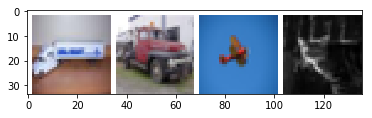

In [5]:
# functions to show an image
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# show some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
net = Net()
#net.cuda()

criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2): # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.182
[1,  4000] loss: 1.810
[1,  6000] loss: 1.680
[1,  8000] loss: 1.591
[1, 10000] loss: 1.549
[1, 12000] loss: 1.488
[2,  2000] loss: 1.452
[2,  4000] loss: 1.377
[2,  6000] loss: 1.359
[2,  8000] loss: 1.346
[2, 10000] loss: 1.300
[2, 12000] loss: 1.286
Finished Training


In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

('GroundTruth: ', '  cat  ship  ship plane')


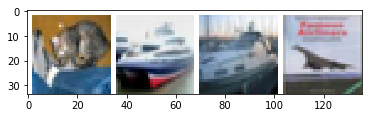

In [33]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [34]:
print labels[0]

3


In [35]:
outputs = net(Variable(images))

In [36]:
print outputs.data


-1.1408 -1.6189  0.8248  2.2502  0.2939  1.4804  1.5867  0.1490 -1.8029 -1.0189
 4.1791  6.3339 -2.1385 -1.7597 -2.9903 -4.1386 -4.0368 -3.4756  6.7468  4.2916
 1.9357  3.1853 -0.8644 -0.7194 -1.5560 -2.3607 -2.1318 -1.9039  3.7528  2.0885
 3.1245  1.6561  0.5857 -1.0106 -0.3505 -2.8400 -2.0721 -2.6521  4.1967  0.3212
[torch.FloatTensor of size 4x10]



In [37]:
# the outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class

# So, let's get the index of the highest energy
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s'% classes[predicted[j][0]] for j in range(4)))

('Predicted: ', '  cat  ship  ship  ship')


In [38]:
print predicted


 3
 8
 8
 8
[torch.LongTensor of size 4x1]



In [39]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [40]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 42 %
Accuracy of   car : 74 %
Accuracy of  bird : 37 %
Accuracy of   cat : 51 %
Accuracy of  deer : 46 %
Accuracy of   dog : 30 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 75 %
Accuracy of truck : 61 %
